<a href="https://colab.research.google.com/github/vdnghia03/Deep-Learning/blob/main/DL4_Data_Aumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## Data augmentation

Readmore:

- [ImageDataGenerator - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=nightly)
- [Data augmentation - wikipedia](https://en.wikipedia.org/wiki/Data_augmentation)

In [21]:
import pandas as pd

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


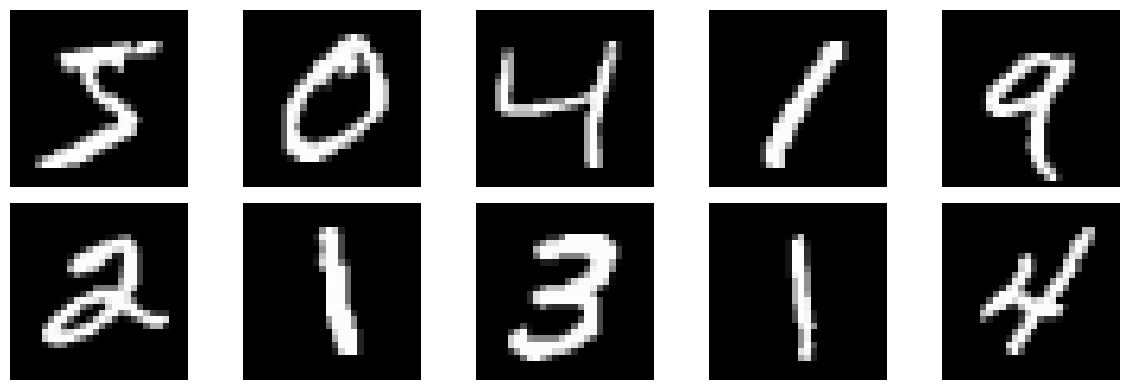

In [2]:
def plot_images(data):
  fig, axes = plt.subplots(2,5, figsize = (12,4))
  for index, ax in enumerate(axes.flatten()):
    ax.imshow(data[index], cmap="gray")
    ax.axis('off')

  plt.tight_layout()

plot_images(X_train)


In [3]:
# Scaler
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(f"{X_train.min()=}, {X_train.max()=}")

X_train.min()=np.float32(0.0), X_train.max()=np.float32(1.0)


---
### Train|val|test split

In [4]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1/6, random_state=42
)

In [5]:
# ImageDataGenerator requires rank 4
X_train_val = X_train_val[:,:,:,None]
X_val = X_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

print(X_train_val.shape)

(50000, 28, 28, 1)


---
### Data augmentation
- ImageDataGenerator to augment images

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.style.use("seaborn-v0_8-white")

train_image_generator = ImageDataGenerator(
    rotation_range=10
    , shear_range = 0.2
    , zoom_range = 0.1
    , horizontal_flip = False
    , height_shift_range = 0.2
    , width_shift_range = 0.2
)

# We don't augment  test data and validation data as we want to test on original data
# we just instantiate an ImageDataGenerator without augmentation
test_image_generator = ImageDataGenerator()

# bath size 32 for mini-batch gradient descent
train_val_generator = train_image_generator.flow(
    X_train_val, y_train_val, batch_size = 32)

# batch size 32 for mini-batch gradient descent
train_generator = train_image_generator.flow(
    X_train, y_train, batch_size = 32)

# batch size 32 for mini-batch gradient descent
val_generator = test_image_generator.flow(
    X_val, y_val, batch_size = 32)

# NumpyArrayIterator
train_val_generator, val_generator


(<keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x7ef9c1f0f0b0>,
 <keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x7ef9c1f71b50>)

2
(32, 28, 28, 1)
(32,)


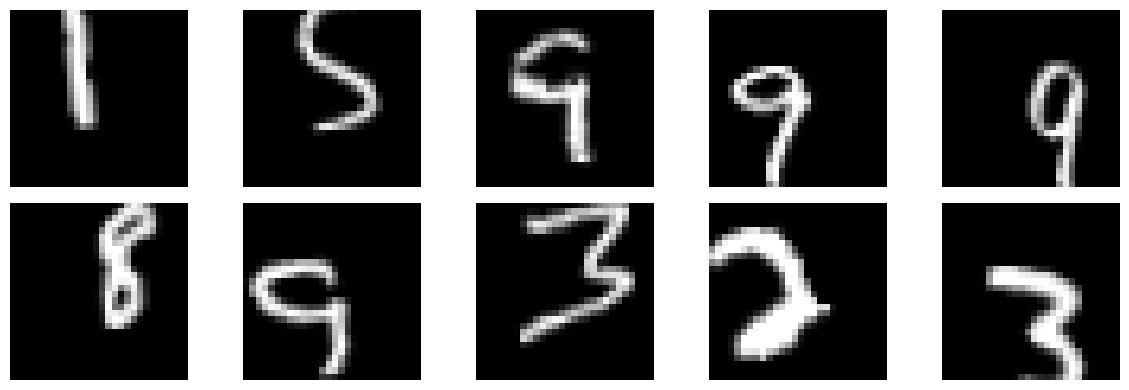

In [15]:

# an iterator can be iterated with a loop as the loop is calling the next() method

print(len(next(train_val_generator)))
print(next(train_val_generator)[0].shape)
print(next(train_val_generator)[1].shape)

plot_images(next(train_val_generator)[0])


---
### CNN model

In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

---
### Train on augmented data
- steps_per_epoch is the number of times we generate our data from the generator
- since we have batches on 32 samples for each time we generate, we could count how many samples before we cover original data size
- 50000/32 =

In [18]:

steps_per_epochs = len(X_train_val)/32
validation_steps = len(X_val)/32

print(f"{steps_per_epochs=}")
print(f"{validation_steps=}")

steps_per_epochs=1562.5
validation_steps=312.5


In [19]:

from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=1500,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator,
    validation_steps=312,
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - acc: 0.6532 - loss: 1.0423 - val_acc: 0.9604 - val_loss: 0.1317
Epoch 2/100
  59/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - acc: 0.8972 - loss: 0.3227

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.8916 - loss: 0.3340 - val_acc: 0.9512 - val_loss: 0.1538
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - acc: 0.9017 - loss: 0.3087 - val_acc: 0.9767 - val_loss: 0.0762
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9205 - loss: 0.2363 - val_acc: 0.9659 - val_loss: 0.1092
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9271 - loss: 0.2282 - val_acc: 0.9714 - val_loss: 0.0955
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9248 - loss: 0.2323 - val_acc: 0.9742 - val_loss: 0.0804
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - acc: 0.9373 - loss: 0.2022 - val_acc: 0.9843 - val_loss: 0.0529
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9477 - loss: 0.1624 - val_acc: 0.9811 - val_loss: 0.0607
Epoch 9/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - acc: 0.9443 - loss: 0.1783 - val_acc: 0.9842 - val_loss: 0.0505
Epoch 10/100
1500/1500 ━━━━━━━━━━━━━

In [22]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,acc,loss,val_acc,val_loss
0,0.790097,0.646815,0.960437,0.131663
1,0.891369,0.334499,0.951222,0.153805
2,0.909116,0.284366,0.976663,0.076198
3,0.920139,0.236965,0.965946,0.109152
4,0.929560,0.220773,0.971354,0.095487


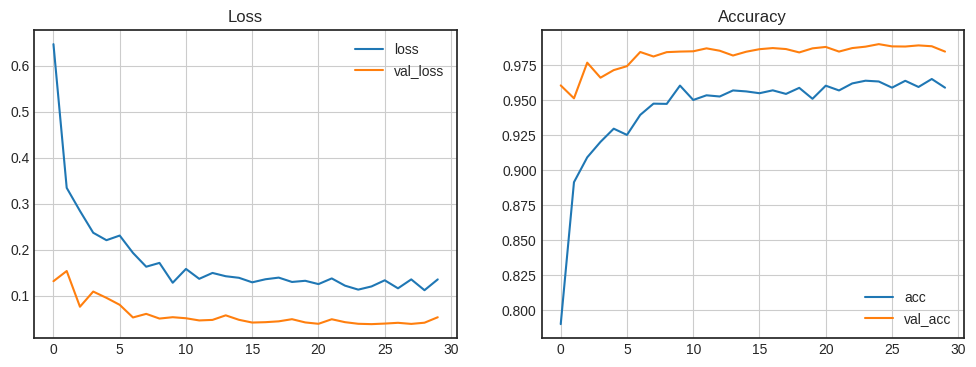

In [24]:
def plot_metrics(metrics):
  _, axes = plt.subplots(1,2, figsize=(12,4))
  metrics[["loss", "val_loss"]].plot(ax=axes[0], title = "Loss", grid = True)
  metrics[["acc", "val_acc"]].plot(ax=axes[1], title = "Accuracy", grid = True)

plot_metrics(metrics)

### Train on all data

In [26]:
fn_steps_per_epoch = len(X_train)/32
print(f"{fn_steps_per_epoch=}")

fn_steps_per_epoch=1875.0


In [27]:
model_final = CNN_model()
model_final.fit(
    train_generator
    , steps_per_epoch = 1875
    , epochs = 30
)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - acc: 0.6768 - loss: 0.9569
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9167 - loss: 0.2649
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9384 - loss: 0.1963
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - acc: 0.9466 - loss: 0.1721
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9521 - loss: 0.1515
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9553 - loss: 0.1412
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9571 - loss: 0.1387
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9605 - loss: 0.1264
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - acc: 0.9618 - loss: 0.1244
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - acc: 0.9643 - loss: 0.1148
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - acc: 0.9654 - loss: 0.1103
Epoch 12/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.9651 - l

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



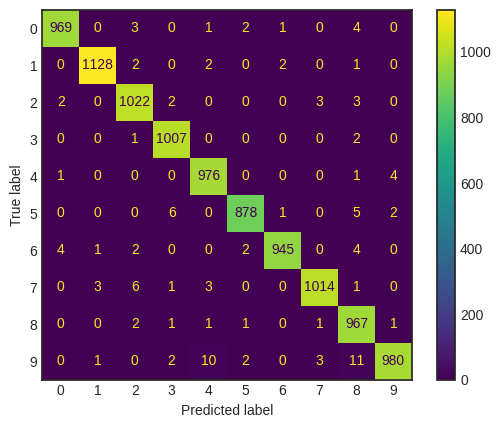

In [28]:

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()